In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, permutation_test_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

In [2]:
%matplotlib inline

In [3]:
plt.rcParams["font.size"] = 16

## Processing datasets

#### 1. reads and cleans up the two dataset

In [4]:
f1 = os.path.join("data", "life_exp.csv")
lf_data = pd.read_csv(f1)
lf_data = lf_data[lf_data["Year"] == 2015].copy()
lf_data[lf_data.isnull().any(axis=1)]
lf_data = lf_data[["Country", "Total expenditure","Status","Alcohol", "Population", "Schooling", " BMI ", "Income composition of resources"]].copy()

In [5]:
f1 = os.path.join("data", "2015.csv")
df_2015 = pd.read_csv(f1)

#### 2. merging the two dataset

In [6]:
df = df_2015.merge(lf_data, on="Country", how="inner")
df[df.isnull().any(axis=1)]
df["Population"].fillna(0, inplace=True)
df[" BMI "].fillna(0, inplace=True)
df["Total expenditure"].fillna(0, inplace=True)
df["Alcohol"].fillna(0, inplace=True)

### Trains and performs ML models on dataset

In [7]:
train, test = train_test_split(df, test_size=0.25, random_state = 0)

In [8]:
xcols = ["Health (Life Expectancy)", "Generosity", "Alcohol","Economy (GDP per Capita)","Total expenditure", "Freedom", "Dystopia Residual", "Income composition of resources"]

In [9]:
lr = LinearRegression()
lr.fit(train[xcols], train["Happiness Score"])
lr.score(test[xcols], test["Happiness Score"])

0.954284436675563

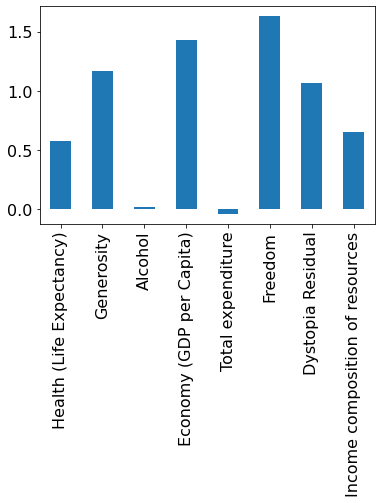

In [10]:
coef_series = pd.Series(lr.coef_, index = xcols)
ax = coef_series.plot.bar()

In [11]:
model = Pipeline([
    ("both", make_column_transformer(
    (StandardScaler(),xcols),
     remainder='passthrough')),
    ("lr", LinearRegression())
])
model.fit(train[xcols], train["Happiness Score"])
model.score(test[xcols], test["Happiness Score"])

0.954284436675563

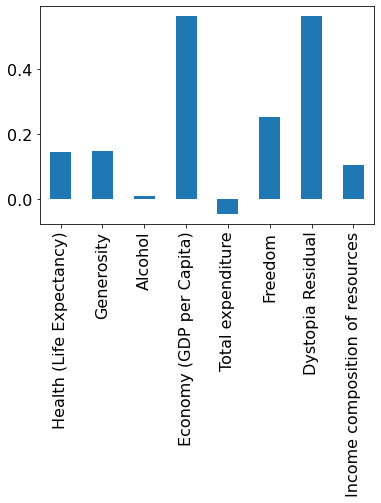

In [12]:
coef_series = pd.Series(model["lr"].coef_, index = xcols)
ax = coef_series.plot.bar()

In [13]:
model2 = Pipeline([
    ("both", make_column_transformer(
    (PolynomialFeatures(degree=2, include_bias=False), xcols),
    remainder='passthrough')),
    ("lr", LinearRegression())
])
model2.fit(train[xcols], train["Happiness Score"])
model2.score(test[xcols], test["Happiness Score"])

0.8972467113011583

In [14]:
train["Happiness Score"].var(), test["Happiness Score"].var()

(1.3783694700990103, 1.2547727887700535)

In [15]:
score = cross_val_score(lr, test[xcols], test["Happiness Score"], cv=5)
score.mean(), score.var()

(0.9436225056484385, 0.0007017627832917213)

In [16]:
score = cross_val_score(model, test[xcols], test["Happiness Score"], cv=5)
score.mean(), score.var()

(0.9436225056484387, 0.0007017627832917224)

In [17]:
score = cross_val_score(model2, test[xcols], test["Happiness Score"], cv=5)
score.mean(), score.var()

(-2.1284875723584173, 3.6411750325627343)

In [18]:
# making happiness to same scale as other features (i.e. out of 1)
df["Happiness Score(out of 1)"] = df["Happiness Score"] / 10

### Plot 1: Descriptive Stats

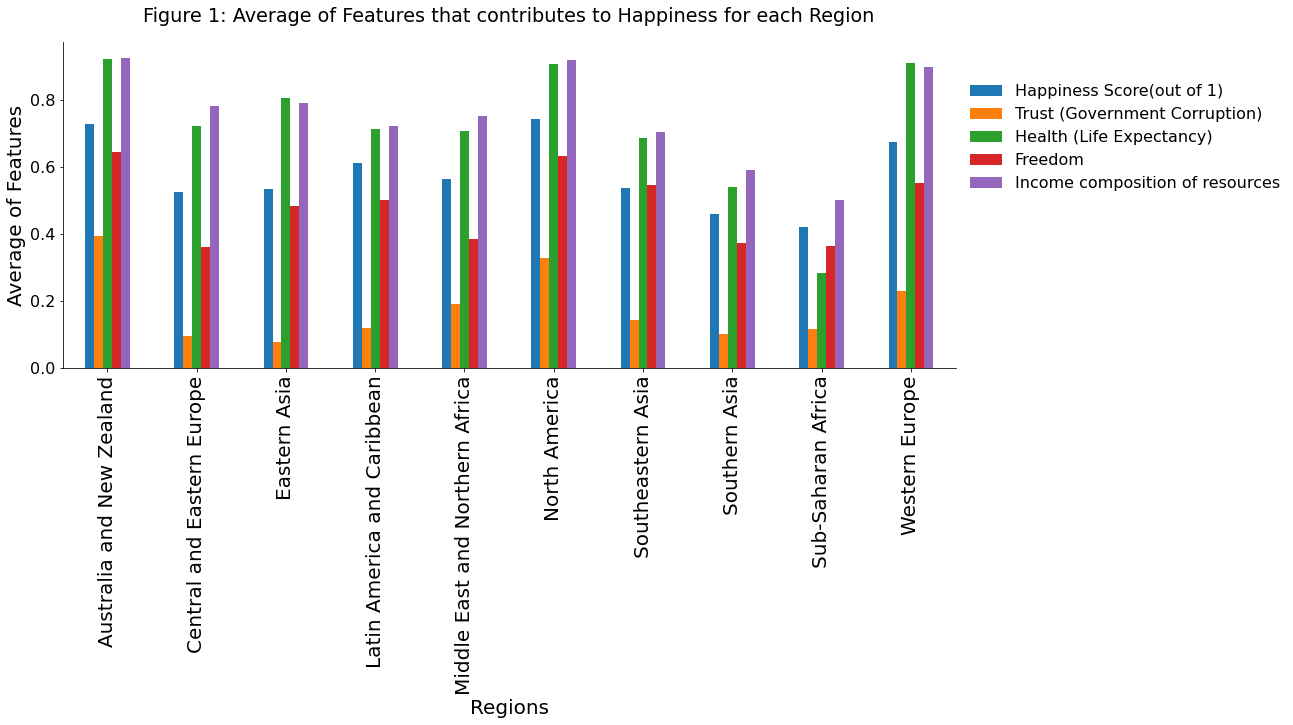

In [19]:
fig, ax = plt.subplots(figsize = (16, 6))
df_plot = df[["Happiness Score(out of 1)","Region", "Trust (Government Corruption)","Health (Life Expectancy)","Freedom", "Income composition of resources"]].groupby("Region").mean()
df_plot.reset_index(inplace = True)
df_plot.plot.bar('Region',["Happiness Score(out of 1)", "Trust (Government Corruption)","Health (Life Expectancy)","Freedom" ,"Income composition of resources"], ax=ax)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_title("Figure 1: Average of Features that contributes to Happiness for each Region", pad=20)
ax.set_ylabel("Average of Features", fontsize=20)
ax.set_xlabel("Regions", fontsize=20)
plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5),  frameon=False)
plt.xticks(fontsize=20)
plt.savefig('fig1.png', bbox_inches='tight')

In [20]:
plot2_scaled = {} 
for i in range(1,8):
    x_norm = StandardScaler().fit_transform(df[xcols])
    pca = PCA(n_components = i)
    vals = pca.fit_transform(x_norm)
    plot2_scaled[i] = sum(pca.explained_variance_ratio_)
    
plot2_not = {} 
for i in range(1,8):
    pca = PCA(n_components = i)
    vals = pca.fit_transform(df[xcols])
    plot2_not[i] = sum(pca.explained_variance_ratio_)

### Plot 2: Unsupervised Learning

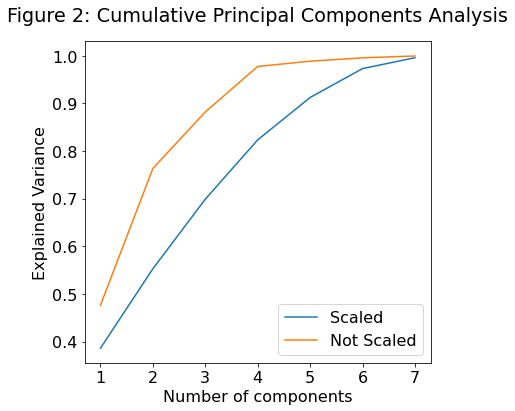

In [21]:
fig, ax = plt.subplots(figsize= (6,6))
ax = pd.Series(plot2_scaled).plot.line(label = "Scaled")
pd.Series(plot2_not).plot.line(label = "Not Scaled", ax=ax)
ax.set_title("Figure 2: Cumulative Principal Components Analysis", pad=20)
ax.set_ylabel("Explained Variance")
ax.set_xlabel("Number of components")
plt.tight_layout()
plt.legend()
plt.savefig('fig2.png', bbox_inches='tight')

In [22]:
col = ["Life-Expectancy", "Generosity", "Alcohol", "GDP per Capita", "Expenditure", "Freedom", "Dystopia Residual", "Income composition"]

### Plot 3: Coefficients of LR model

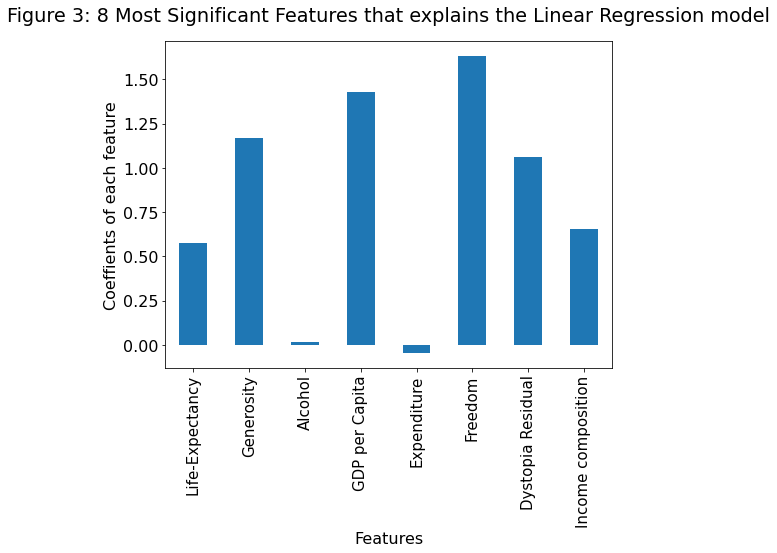

In [23]:
fig, ax = plt.subplots(figsize = (8, 6))
coef_series = pd.Series(lr.coef_, index = col)
coef_series.plot.bar(ax=ax)
ax.set_xlabel("Features")
ax.set_ylabel("Coeffients of each feature")
plt.xticks(fontsize= 15) 
ax.set_title("Figure 3: 8 Most Significant Features that explains the Linear Regression model", pad=20)
plt.savefig('fig3.png', bbox_inches='tight')